안녕하세요! 이번 대회 Host 김동규입니다. 이번 대회는 8월에 있었던 AI 집중 교육의 연장선상으로 classical ML 데이터를 이용한 대회입니다. 집중교육 때는 숫자로 이루어진 데이터만 사용했다면, 이번 대회는 대부분 문자로 된 데이터가 중심이 됩니다. categorical variable을 어떻게 잘 변형하고 새로운 feature로 만들어내는지가 중요한 대회입니다.

아래는 간단한 베이스라인입니다. 대회에 submission 할 수 있는 최소한의 코드로 구성되어 있습니다. 아래 코드를 기반으로 하여 점수를 향상하고 리더보드의 상단에 위치하여 보세요!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pceo-ai-club1/sample_submission.csv
/kaggle/input/pceo-ai-club1/train.csv
/kaggle/input/pceo-ai-club1/test.csv


In [2]:
# 파이프라인 어떻게 쓸지

In [3]:
# unique확인

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
import xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display
import matplotlib.pyplot as plt

import warnings

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna import Trial

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

In [5]:
train = pd.read_csv('../input/pceo-ai-club1/train.csv', index_col="student_id") #반드시 index_col을 student_id로 설정해주세요
test = pd.read_csv('../input/pceo-ai-club1/test.csv', index_col="student_id")
sample_submission = pd.read_csv('../input/pceo-ai-club1/sample_submission.csv', index_col="student_id")

# Super Simple EDA

In [6]:
train.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest
student_id,,,,,,,,,
W20C6,GOOBU,Urban,Public,HKF,Standard,28.0,Female,Qualifies for reduced/free lunch,34.0
A3JJP,GOOBU,Urban,Public,W8A,Experimental,26.0,Female,Qualifies for reduced/free lunch,36.0
UBDCF,DNQDD,Suburban,Public,PW5,Experimental,20.0,Male,Qualifies for reduced/free lunch,42.0
QQJEC,GOOBU,Urban,Public,W8A,Experimental,26.0,Female,Qualifies for reduced/free lunch,36.0
3SWL5,UUUQX,Suburban,Non-public,SSP,Standard,15.0,Female,Does not qualify,66.0


In [7]:
test.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch
student_id,,,,,,,,
MNVG5,VHDHF,Rural,Non-public,KR1,Experimental,15.0,Female,Qualifies for reduced/free lunch
LB2TH,GJJHK,Suburban,Public,ZDT,Standard,27.0,Male,Qualifies for reduced/free lunch
ETDRG,CIMBB,Urban,Non-public,PC6,Standard,17.0,Female,Does not qualify
TME5H,GOKXL,Rural,Public,VA6,Standard,19.0,Female,Qualifies for reduced/free lunch
G8C0U,QOQTS,Urban,Public,3XJ,Standard,24.0,Female,Does not qualify


In [8]:
train.isnull().any()

school             False
school_setting     False
school_type        False
classroom          False
teaching_method    False
n_student          False
gender             False
lunch              False
pretest            False
dtype: bool

위에서 보다시피 데이터에 null 값은 없습니다.

# Data Preprocessing

In [9]:
y = train.pretest
X_no_school = train.drop(["school_setting","pretest"], axis=1)
X_yes_school = train[["school_setting"]]

test_no_school = test.drop(["school_setting"], axis=1)
test_yes_school = test[["school_setting"]]

# **One-hotencoding**

In [10]:
X_yes_school

,school_setting
student_id,
W20C6,Urban
A3JJP,Urban
UBDCF,Suburban
QQJEC,Urban
3SWL5,Suburban
...,...
XL3MD,Rural
7T7C2,Urban
XDNY7,Rural


In [11]:
test_yes_school

,school_setting
student_id,
MNVG5,Rural
LB2TH,Suburban
ETDRG,Urban
TME5H,Rural
G8C0U,Urban
...,...
583ZR,Rural
GGT4A,Urban
3S4PV,Suburban


In [12]:
# one-hot-encoding
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
X_yes_school_onehot = onehot_encoder.fit_transform(X_yes_school["school_setting"].values.reshape(-1,1))
test_yes_school_onehot = onehot_encoder.transform(test_yes_school["school_setting"].values.reshape(-1,1))

X_yes_school_onehot = pd.DataFrame(X_yes_school_onehot.toarray(), columns = ["Rural", "Suburban", "Urban"], index=list(train.index.values))
test_yes_school_onehot = pd.DataFrame(test_yes_school_onehot.toarray(), columns = ["Rural", "Suburban", "Urban"], index=list(test.index.values))

print(X_yes_school_onehot)
print(test_yes_school_onehot)
print(onehot_encoder.categories_)
# 판다스 넘파이 파이썬 기본리스트

       Rural  Suburban  Urban
W20C6    0.0       0.0    1.0
A3JJP    0.0       0.0    1.0
UBDCF    0.0       1.0    0.0
QQJEC    0.0       0.0    1.0
3SWL5    0.0       1.0    0.0
...      ...       ...    ...
XL3MD    1.0       0.0    0.0
7T7C2    0.0       0.0    1.0
XDNY7    1.0       0.0    0.0
AKDEM    0.0       0.0    1.0
UIM0F    0.0       1.0    0.0

[1706 rows x 3 columns]
       Rural  Suburban  Urban
MNVG5    1.0       0.0    0.0
LB2TH    0.0       1.0    0.0
ETDRG    0.0       0.0    1.0
TME5H    1.0       0.0    0.0
G8C0U    0.0       0.0    1.0
...      ...       ...    ...
583ZR    1.0       0.0    0.0
GGT4A    0.0       0.0    1.0
3S4PV    0.0       1.0    0.0
FDPKM    0.0       0.0    1.0
W4M1T    0.0       0.0    1.0

[427 rows x 3 columns]
[array(['Rural', 'Suburban', 'Urban'], dtype=object)]


# Ordinal-encoding

In [13]:
s = (X_no_school.dtypes == 'object')
object_cols = list(s[s].index)
object_cols

['school', 'school_type', 'classroom', 'teaching_method', 'gender', 'lunch']

n_students 이외의 feature들은 모두 categorical입니다. (cateogical => 문자 형태)

In [14]:
label_X = X_no_school.copy()
label_test = test_no_school.copy()

ordinal_encoder = OrdinalEncoder()
label_X[object_cols] = ordinal_encoder.fit_transform(X_no_school[object_cols])
label_test[object_cols] = ordinal_encoder.transform(test_no_school[object_cols])

label_X = pd.DataFrame(label_X)
label_test = pd.DataFrame(label_test)

In [15]:
label_X.head()

,school,school_type,classroom,teaching_method,n_student,gender,lunch
student_id,,,,,,,
W20C6,8.0,1.0,45.0,1.0,28.0,0.0,1.0
A3JJP,8.0,1.0,83.0,0.0,26.0,0.0,1.0
UBDCF,4.0,1.0,65.0,0.0,20.0,1.0,1.0
QQJEC,8.0,1.0,83.0,0.0,26.0,0.0,1.0
3SWL5,17.0,0.0,73.0,1.0,15.0,0.0,0.0


In [16]:
label_test.head()

,school,school_type,classroom,teaching_method,n_student,gender,lunch
student_id,,,,,,,
MNVG5,18.0,0.0,53.0,0.0,15.0,0.0,1.0
LB2TH,6.0,1.0,95.0,1.0,27.0,1.0,1.0
ETDRG,2.0,0.0,62.0,1.0,17.0,0.0,0.0
TME5H,7.0,1.0,82.0,1.0,19.0,0.0,1.0
G8C0U,14.0,1.0,15.0,1.0,24.0,0.0,0.0


# **이어붙여주기**

In [17]:
X = pd.concat([label_X, X_yes_school_onehot], axis=1)
test_complete = pd.concat([label_test, test_yes_school_onehot], axis=1)
# New_X = pd.concat(frames)
# display(New_X)
# print(frames)
X

# 왜 원핫한거 인덱스 주고, axis 1을 주니깐 해결이 되는거지??

,school,school_type,classroom,teaching_method,n_student,gender,lunch,Rural,Suburban,Urban
W20C6,8.0,1.0,45.0,1.0,28.0,0.0,1.0,0.0,0.0,1.0
A3JJP,8.0,1.0,83.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0
UBDCF,4.0,1.0,65.0,0.0,20.0,1.0,1.0,0.0,1.0,0.0
QQJEC,8.0,1.0,83.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0
3SWL5,17.0,0.0,73.0,1.0,15.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
XL3MD,19.0,1.0,35.0,1.0,21.0,1.0,0.0,1.0,0.0,0.0
7T7C2,2.0,0.0,37.0,1.0,21.0,1.0,0.0,0.0,0.0,1.0
XDNY7,11.0,1.0,17.0,1.0,24.0,0.0,1.0,1.0,0.0,0.0
AKDEM,14.0,1.0,84.0,0.0,25.0,0.0,0.0,0.0,0.0,1.0


categorical variable을 숫자로 잘 바꾸어 주었습니다. Ordinal Encoder에 대해 잊어버린 분들은 kaggle course를 참고하세요.



random state는 같은 모델에 결과를 여러번 실행했을때 같게 만들어주기 위한 녀석임!

# K-means

In [18]:
kmeans = KMeans(n_clusters=3)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,school,school_type,classroom,teaching_method,n_student,gender,lunch,Rural,Suburban,Urban,Cluster
W20C6,8.0,1.0,45.0,1.0,28.0,0.0,1.0,0.0,0.0,1.0,0
A3JJP,8.0,1.0,83.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,2
UBDCF,4.0,1.0,65.0,0.0,20.0,1.0,1.0,0.0,1.0,0.0,0
QQJEC,8.0,1.0,83.0,0.0,26.0,0.0,1.0,0.0,0.0,1.0,2
3SWL5,17.0,0.0,73.0,1.0,15.0,0.0,0.0,0.0,1.0,0.0,2


In [19]:
X['Cluster'] = pd.to_numeric(X['Cluster'])

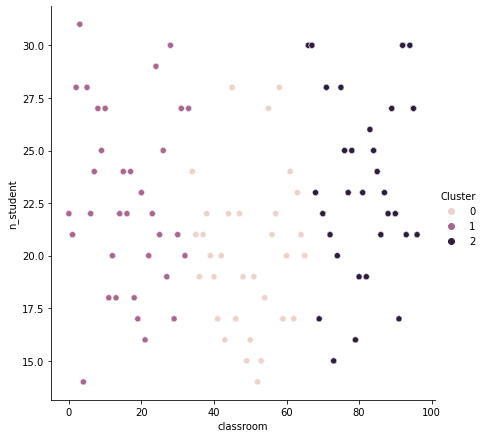

In [20]:
sns.relplot(
    x="classroom", y="n_student", hue="Cluster", data=X, height=6,
); 

In [21]:
kmeans = KMeans(n_clusters=6)
test_complete["Cluster"] = kmeans.fit_predict(test_complete)
test_complete["Cluster"] = test_complete["Cluster"].astype("category")

test_complete.head()

,school,school_type,classroom,teaching_method,n_student,gender,lunch,Rural,Suburban,Urban,Cluster
MNVG5,18.0,0.0,53.0,0.0,15.0,0.0,1.0,1.0,0.0,0.0,2
LB2TH,6.0,1.0,95.0,1.0,27.0,1.0,1.0,0.0,1.0,0.0,1
ETDRG,2.0,0.0,62.0,1.0,17.0,0.0,0.0,0.0,0.0,1.0,2
TME5H,7.0,1.0,82.0,1.0,19.0,0.0,1.0,1.0,0.0,0.0,1
G8C0U,14.0,1.0,15.0,1.0,24.0,0.0,0.0,0.0,0.0,1.0,0


In [22]:
test_complete['Cluster'] = pd.to_numeric(test_complete['Cluster'])

In [23]:
type(test_complete['Cluster'])
# 판다스 시리즈 구글링이나 기초

pandas.core.series.Series

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=3, shuffle=True)
# # kfold cross validition 해보기

# Model train

# Optuna test

In [25]:
# def lgbm_objective(trial):
#     # To select which parameters to optimize, please look at the XGBoost documentation:
#     # https://xgboost.readthedocs.io/en/latest/parameter.html
#     param = {
#         "objective": "regression",
#         "metric": "mae",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     }
#     model = LGBMRegressor(**param)  
    
#     model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)
    
#     preds = model.predict(X_val)
    
#     mae = mean_absolute_error(y_val, preds)
    
#     return mae

In [26]:
# study = optuna.create_study(direction='minimize')
# study.optimize(lgbm_objective, n_trials=2)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [27]:
# lgbm_params = {'lambda_l1': 0.5200298693537239, 
#                'lambda_l2': 1.0774696077969569e-05, 
#                'num_leaves': 35, 
#                'feature_fraction': 0.46695498134027, 
#                'bagging_fraction': 0.807491141571741, 
#                'bagging_freq': 6, 
#                'min_child_samples': 79}
# model = LGBMRegressor(**lgbm_params)  
    
# model.fit(X_train,y_train,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False)

# preds = model.predict(X_val)

# mae = mean_absolute_error(y_val, preds)

# print(mae)

# # 7000번 돌려본 하이퍼 파라미터 mae -> 0.5090937419732455

In [28]:
# # optuna lgbm predict
# pred_lgb_optuna = model.predict(test_complete)

그다지 성능이 좋진 않았다..........

# Ensemble_build_Up

In [29]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# xgboost

In [30]:
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.08, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [31]:
score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[11:41:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:41:34] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:41:35] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:41:36] WARNI

# lgbm

In [32]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.08, n_estimators=20000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11
                             )

In [33]:
score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

# 3.206 -> estimators = 1500
# 3.306 -> estimaotrs = 1000
# 3.1939 -> estimaotrs = 115000 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6

# Catboostregressor

In [34]:
model_CBR = CatBoostRegressor(iterations=1900,
                              learning_rate=0.08,
                              depth=4,
                              l2_leaf_reg=20,
                              bootstrap_type='Bernoulli',
                              subsample=0.6, eval_metric='RMSE',
                              metric_period=50, od_type='Iter',
                              od_wait=45, random_seed=17,
                              allow_writing_files=False, verbose=False
                                )

In [35]:
score = rmsle_cv(model_CBR)
CBR_score = score.mean()
print("CatBoostRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

# 3.22 -> 2000
# 3.2255 -> iteration

CatBoostRegressor score: 3.2189 (0.1913)


# Model fit & predict

In [36]:
model_xgb.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)
model_CBR.fit(X_train, y_train)

[11:42:04] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [37]:
type(X['Cluster'])

pandas.core.series.Series

In [38]:
pred_xgb = model_xgb.predict(test_complete)
pred_lgb = model_lgb.predict(test_complete)
pred_CBR = model_CBR.predict(test_complete)

# 결과값 ensemble

In [39]:
pred_ensemble = (pred_xgb + pred_lgb + pred_CBR)/3

In [40]:
# pred_ensemble = (pred_lgb_optuna + pred_xgb + pred_CBR)/3

In [41]:
# total_weight = (1. / gb_score) + (1. / xgb_score) + (1. / lgb_score)
# pred = (pred_gb * (1. / gb_score) + pred_xgb * (1. / xgb_score) +  pred_lgb * (1. / lgb_score)) / total_weight
# mean_absolute_error(pred, y_val)

# Submit

In [42]:
pd_test_pred = pd.DataFrame(pred_ensemble,columns=["pretest"], index=label_test.index)
pd_test_pred.to_csv('kmeans1.csv')

근데 이렇게 구글링해서 지리는 모델 참고해서 적용하면 실력이 과연 늘지 걱정됌

오버피팅 조절 = xgboost, k fold crossvalidation해보기, feature engineering 해볼것

validaition도 앙상블하고 평가

xgb, lgbm, catboost해보기, optuna, sudo labeling, validaiton해보기, accuracy, mae

규칙을 가지고 해보기, cross validation하고, feature engineering, lgbm이 쫌 좋음, 옵튜나 돌릴것, 뉴럴 네트워크 딥노이징, 간 알고리즘해보면 옵튜나 따라오길 쉽지 않다. kmeans나 pca  

cross validation해보면 private 에 더 가까운 점수가능

수도 라벨링 앙상블 멀티모델은 나중에 많이 한다. 하나의 모델이 잘나올때좋음

쉬운거 먼저, 싱글모델링,

2.68001 lgbm estimater랑 learning rate 조절

lgbm 성능 개좋음

cv = cross-validation

새로운 앙상블 기법 시도해보기

원핫 없애버리기

rmse도 보기

lgbm 하이퍼 파라미타 복원하기

k-means clusting

1. 초반에 k개의 cluster를 모을지 정하기
2. 무지성으로 centroid를 찍기
3. centroid 주변의 데이터들을 감지하고 그녀석들의 평균 가운데의 거리를 구하고 그쪽으로 centroid를 이동
4. 점점 다른데이터들도 centroid의 주변을감지하고 데이터간의 평균 가운데의 거리를 구한뒤 데이터들의 중간지점으로 계속해서 이동
5. cluster형성

In [43]:
# 다른 모델 결과값 두개를 평균내는 앙상블

In [44]:
# 앙상블해보기

In [45]:
# 베이스라인코드

In [46]:
# result = model_xgb.predict(test_complete)

In [47]:
# submission = pd.DataFrame(result,columns=["pretest"], index=label_test.index)

In [48]:
# submission.to_csv("xgb1.csv")